In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy

In [14]:
import math
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm

# Step 1: Construct TFIM matrix H
n = 4  # Data qubits (system qubits)
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))

H_tfim = qml.Hamiltonian(coeffs, ops)
H_mat = qml.matrix(H_tfim)
# Step 5: Exact Ground State Calculation using NumPy's linalg.eig
eigenvalues, eigenvectors = np.linalg.eig(H_mat)

min_index = np.argmin(eigenvalues)
min_eigenvalue = eigenvalues[min_index]
min_eigenvector = eigenvectors[:, min_index]

H_mat -= min_eigenvalue * np.eye(2**n)
# Step 2: LCU form of cos^{2m}(H)
m = 2
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
U_k = [expm(2j * k * H_mat) for k in k_vals]
U_k_ops = [qml.QubitUnitary(U, wires=range(n)) for U in U_k]
cos2m_op = qml.dot(alpha_k, U_k_ops)
# Step 3: Define Qubitization circuit
n_control = int(np.ceil(np.log2(len(alpha_k))))
control_wires = [n + i for i in range(n_control)]  # control wires for ancilla qubits
aux_wire = n + n_control

# Define a device with n + 1 qubits (4 data qubits + 1 ancilla qubit)
dev = qml.device("default.qubit", wires=n + n_control)

@qml.qnode(dev)
def circuit():
    # Prepare nontrivial input eigenstate (Hadamard on all qubits)
    for i in range(n):
        qml.Hadamard(i)

    # Apply Qubitization to create the state
    qml.Qubitization(cos2m_op, control=control_wires)

    # Return the final state vector
    return qml.state()

# Step 4: Run the circuit and get the state vector
state_vector = circuit()[:2**n]
state_vector/=np.linalg.norm(state_vector)

# Print results
state0 = qml.math.dm_from_state_vector(min_eigenvector)
state1 = qml.math.dm_from_state_vector(state_vector)
print('fidelity is :', qml.math.fidelity(state0, state1))


fidelity is : 0.29054008950002963


In [19]:
qml.version()

'0.41.1'

In [59]:
import math
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm

n = 4  # system qubits
m = 8  # for cos^{2m}(H)
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
k_vals = [k for k in range(-m, m + 1) if alpha_k[k + m] > 1e-4]
# Step 1: Build and normalize Hamiltonian
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H_tfim = qml.Hamiltonian(coeffs, ops)
H_mat_raw = qml.matrix(H_tfim)
eigvals = np.linalg.eigvalsh(H_mat_raw)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_mat = (H_mat_raw - λ_min * np.eye(2**n)) / (λ_max - λ_min)  # Normalize to [0,1]
H_eigs, H_vecs = np.linalg.eigh(H_mat)
λ0 = np.min(H_eigs)
H_mat -= λ0 * np.eye(2**n)  # shift ground energy to 0

# Step 2: pad alpha_k to next power of 2
pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))  # 8
alpha_padded = np.zeros(pad_len)
alpha_padded[:len(alpha_k)] = alpha_k
weights = np.sqrt(alpha_padded / np.sum(alpha_padded))

n_anc = int(np.log2(len(alpha_padded)))  # 3 ancilla qubits
dev = qml.device("default.qubit", wires=n + n_anc)

@qml.qnode(dev)
def circuit():
    # Trial state: Hadamard on all system qubits
    for i in range(n):
        qml.Hadamard(i)

    # PREP: Mottonen state on ancilla
    qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))

    # SELECT: controlled unitaries (identity for padded ones)
    U_list = [expm(2j * (k - m) * H_mat) for k in range(len(alpha_k))]  # real unitaries
    for _ in range(pad_len - len(U_list)):
        U_list.append(np.eye(2**n))  # padded identity

    for idx, U in enumerate(U_list):
        bin_str = format(idx, f"0{n_anc}b")
        ctrl_wires = [n + i for i, b in enumerate(bin_str) if b == '1']
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=range(n))

    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))

    return qml.state()

# Run circuit
full_state = circuit()
reshaped = full_state.reshape((2**n, 2**n_anc))
system_state = reshaped[:, 0]  # 第 0 列表示 ancilla = 000


main_state = system_state/ np.linalg.norm(system_state)

# Compare with exact ground state
ground_state = H_vecs[:, 0]
#ground_state /= np.linalg.norm(ground_state)
fidelity = np.abs(np.vdot(main_state, ground_state))**2
print("Fidelity with true ground state:", fidelity)
success_prob = np.sum(np.abs(system_state**2))
print("Success probability:", success_prob)


Fidelity with true ground state: 0.9719761950997663
Success probability: 0.836898989444578


In [50]:
m = 6
k_vals = np.arange(-m, m + 1)
a = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
a

tensor([0.00024414, 0.00292969, 0.01611328, 0.05371094, 0.12084961,
        0.19335938, 0.22558594, 0.19335938, 0.12084961, 0.05371094,
        0.01611328, 0.00292969, 0.00024414], requires_grad=True)

In [52]:
2**(-2 * m)

0.000244140625

(<Figure size 2100x900 with 1 Axes>, <Axes: >)


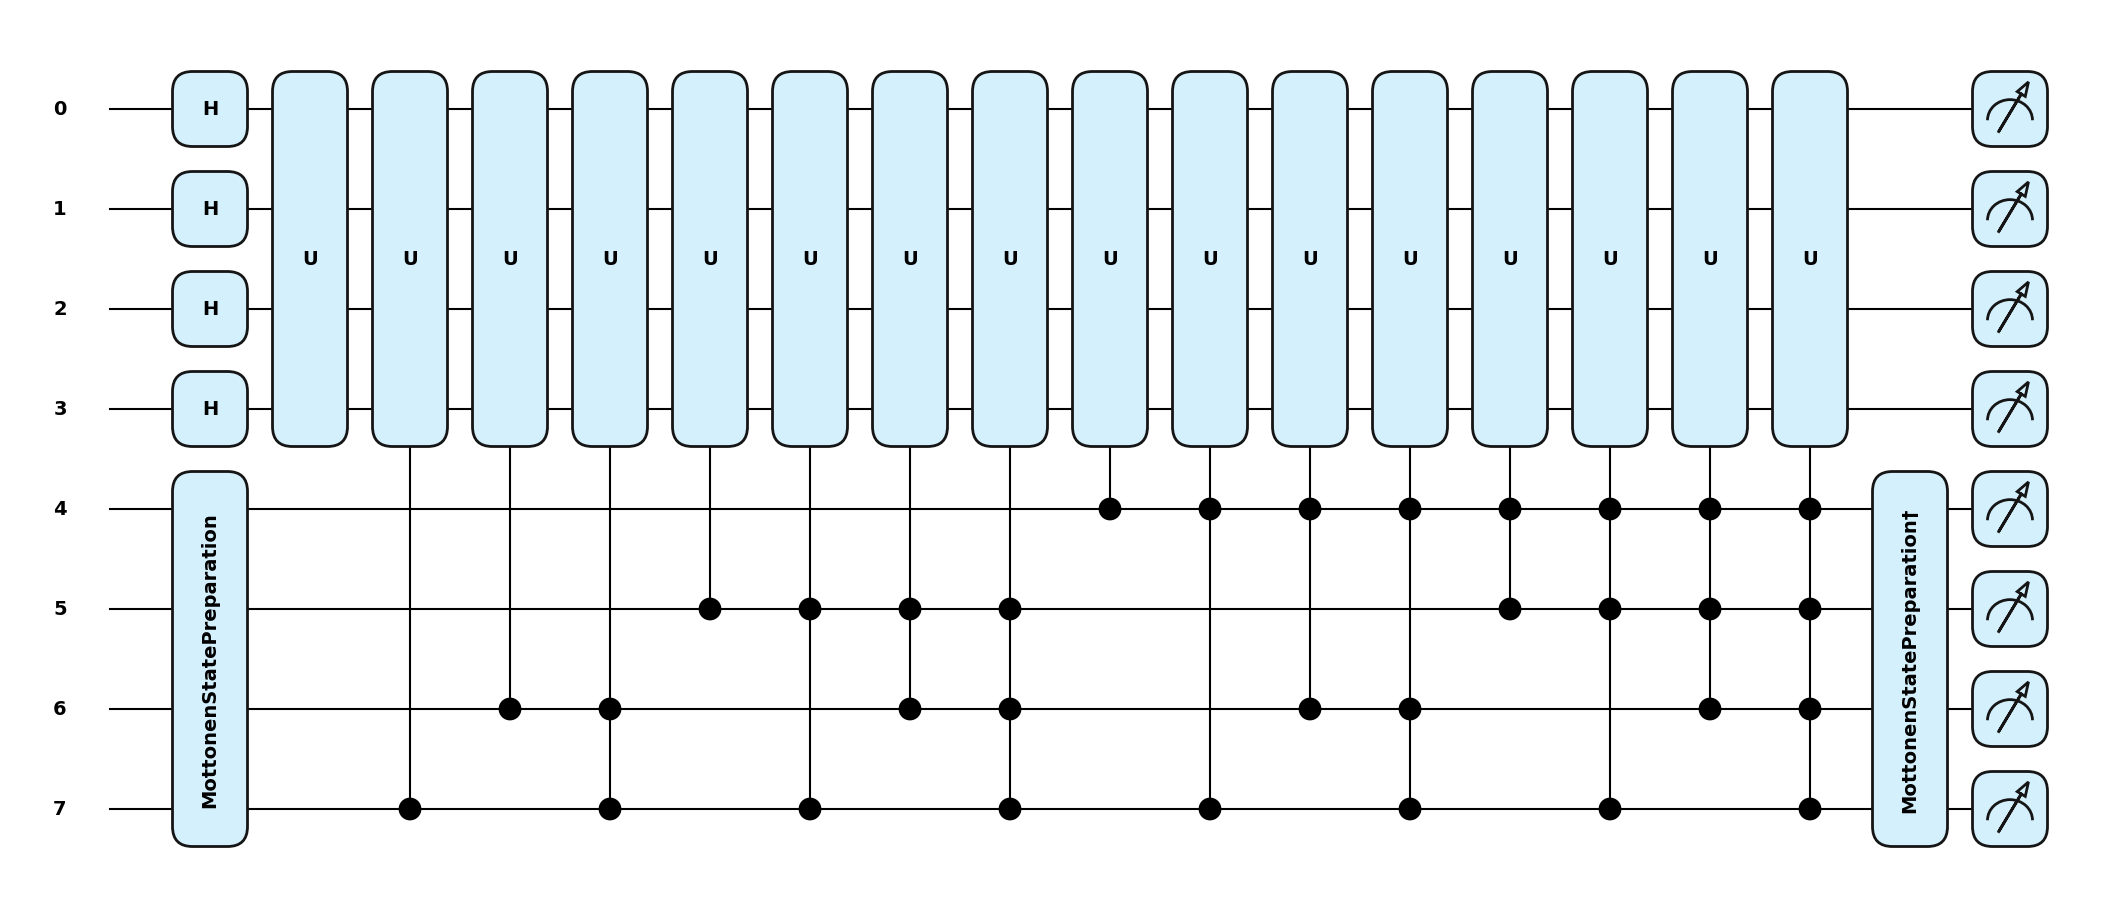

In [53]:
circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())

In [126]:
##exact
a = np.linalg.matrix_power(scipy.linalg.cosm(H_mat), 2*m)
b = qml.matrix(cos2m_op)
frobenius_norm = np.linalg.norm(a - b, 'fro')

print("Frobenius norm:", frobenius_norm)

Frobenius norm: 8.973102418582736e-16


In [3]:
A = np.array([[0, 1], [-1, 0]])
print("cos(A):\n", scipy.linalg.cosm(A))

cos(A):
 [[1.54308063 0.        ]
 [0.         1.54308063]]


In [5]:
np.cosh(1)

np.float64(1.5430806348152437)

Matplotlib is building the font cache; this may take a moment.


(<Figure size 400x900 with 1 Axes>, <Axes: >)


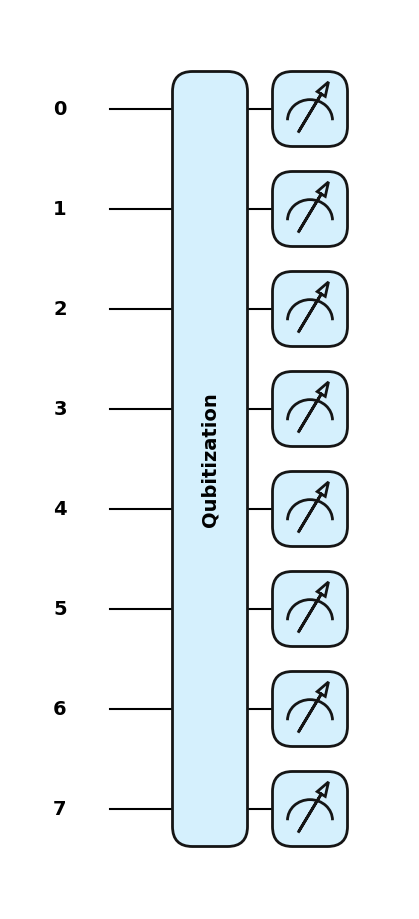

In [9]:
circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())

projector |0><0|

In [87]:
## projector
import pennylane as qml
import numpy as np

# 定义量子设备
dev = qml.device('default.qubit', wires=2)

# 投影算符示例（Pauli-Z 和 Identity 的线性组合）
coeffs = np.array([1/2, 1/2])
proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

# 使用 Qubitization 进行投影算符的量子化
@qml.qnode(dev)
def qubitization_circuit():
    # 使用 Qubitization 类来进行 qubitization
    qml.Hadamard(0)
    qml.RX(np.pi/2,[0])
    qml.Qubitization(qml.dot(coeffs,proj_unitaries), [1])  # 使用投影算符

    # 返回最终的量子态
    return qml.state()

# 绘制电路图
circuit_diagram = qml.draw_mpl(qubitization_circuit, style='pennylane')

# 执行并打印量子态
state = qubitization_circuit()[:2**1].real
state/=np.linalg.norm(state)
print(state)


qubitization_circuit().shape

[1. 0.]


(4,)

(<Figure size 600x300 with 1 Axes>, <Axes: >)


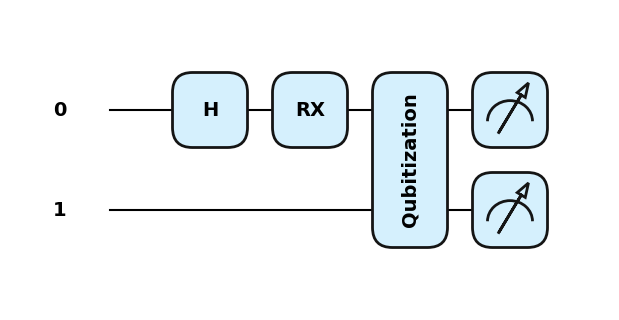

In [89]:
# 打印电路图
print(circuit_diagram())

### QSVT

In [2]:
target_poly = [0, -3 * 0.5, 0, 5 * 0.5]
target_poly[::-1]

[2.5, 0, -1.5, 0]

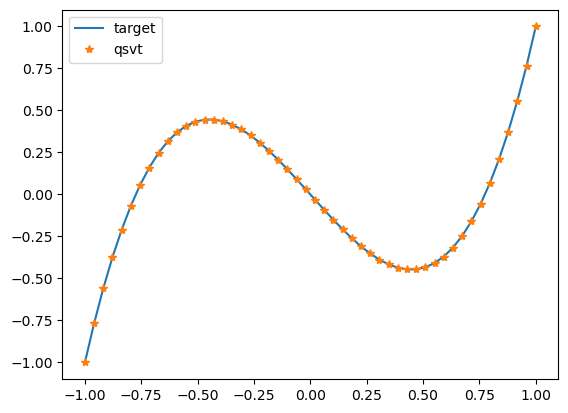

In [8]:
## qsvt
import matplotlib.pyplot as plt
def qsvt_circuit(a):
    qc = qml.qsvt(a, target_poly, encoding_wires=[0], block_encoding='embedding')
    return qc

def qsvt_out(a):
    qc = qsvt_circuit(a)
    out = qml.matrix(qc)
    return out[0,0]

a_vals = np.linspace(-1, 1, 50)
qsvt = [np.real(qsvt_out(a)) for a in a_vals]
target = [np.polyval(target_poly[::-1], a) for a in a_vals]

plt.plot(a_vals, target, label='target')
plt.plot(a_vals, qsvt, '*', label='qsvt')

plt.legend()
plt.show()
